In [1]:
# Data stuff
import numpy as np
import pandas as pd
import dask.dataframe as dd

# Visual stuff
from IPython.display import display
# Configs 
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Random state seed
rand_state=42

# ML stuff
import sklearn
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import shap

# Dask
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.  Launch dashboard

# Prepa data-set for models

In [2]:
# Import and display data-set
dataset = dd.read_csv('../data_gen/dataset_mean_entire/*.part')
# Ensure correct types
dataset = dataset.astype(dtype={
    'gender':int,
    'ethnicity_AMERICAN INDIAN/ALASKA NATIVE':int,
    'ethnicity_ASIAN':int,
    'ethnicity_BLACK/AFRICAN AMERICAN':int,
    'ethnicity_HISPANIC/LATINO':int,
    'ethnicity_WHITE':int,
    'insurance_Medicaid':int,
    'insurance_Medicare':int,
    'marital_status_DIVORCED':int,
    'marital_status_MARRIED':int,
    'marital_status_SINGLE':int,
    'marital_status_WIDOWED':int,
    'language_english':int,
    'hospital_expire_flag':int,
})
# Order ints(categorical variables) and floats(number variables)
dataset = dataset[[
 'ethnicity_AMERICAN INDIAN/ALASKA NATIVE',
 'ethnicity_ASIAN',
 'ethnicity_BLACK/AFRICAN AMERICAN',
 'ethnicity_HISPANIC/LATINO',
 'ethnicity_WHITE',
 'insurance_Medicaid',
 'insurance_Medicare',
 'marital_status_DIVORCED',
 'marital_status_MARRIED',
 'marital_status_SINGLE',
 'marital_status_WIDOWED',
 'gender',
 'language_english',
 'hospital_expire_flag',
 'age_at_admission',
 'seq_num',
 'times_prev_admitted',
 'length_of_stay(days)',
 'BMI',
 'Glucose',
 'Potassium',
 'Sodium',
 'Chloride',
 'Bicarbonate',
 'Anion Gap',
 'Creatinine',
 'Urea Nitrogen',
 'Magnesium',
 'Hematocrit',
 'Hemoglobin',
 'Platelet Count',
 'Phosphate',
 'Calcium, Total',
 'White Blood Cells',
 'Red Blood Cells',
 'MCH',
 'RDW',
 'MCV',
 'pH',
 'PTT',
 'PT',
 'H'
]].compute()

In [3]:
# Generate data set withouth categories(all numbers)
Y_no_cat = dataset.hospital_expire_flag.values
X_no_cat = dataset.drop(columns=['hospital_expire_flag']).values

# dataset as is, but target variable dropped(hospital expire flag)
dataset_no_target = dataset.drop(columns=['hospital_expire_flag'])

# Feture names and categorical feature names
feature_names = dataset_no_target.select_dtypes(include='int').columns.values.tolist() + dataset_no_target.select_dtypes(exclude='int').columns.values.tolist() 
cat_feature_names = dataset_no_target.select_dtypes(include='int').columns.values.tolist() 

# Generate data set with categories(int type required)
dataframe_int_list = dataset_no_target.select_dtypes(include='int').values.tolist()
dataframe_no_int_list = dataset_no_target.select_dtypes(exclude='int').values.tolist()
Y = dataset.hospital_expire_flag.values.tolist()
X = []
for i,v in enumerate(dataframe_int_list):
    X = X + [v+dataframe_no_int_list[i]]

# Generate categorical feature indicies
cat_features_indices=list(range(0,len(dataframe_int_list[0])))

# Define functions and variables

In [4]:
# Function that w
def strat_cv_it(classifier, params, uses_cat, param_comb ):
    folds = 3
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = rand_state)
    
    # Perform fit and scoring
    if uses_cat:
        random_search = RandomizedSearchCV( classifier, return_train_score=True, param_distributions=params ,scoring='roc_auc', n_iter=param_comb, n_jobs=4, cv=skf.split(X, Y),random_state = rand_state, refit=True, verbose=3,  )
        random_search.fit(X, Y)     
    else:
        random_search = RandomizedSearchCV( classifier, return_train_score=True, param_distributions=params ,scoring='roc_auc', n_iter=param_comb, n_jobs=4, cv=skf.split(X_no_cat, Y_no_cat),random_state = rand_state, refit=True, verbose=3)
        random_search.fit(X_no_cat, Y_no_cat)
    
    # Display results and return best model
    display(random_search.best_score_)
    display(random_search.best_params_)
    display(pd.DataFrame(random_search.cv_results_))
    return random_search.best_estimator_

# Scale of negative class to the positive class(#survived/#died)
scale_pos_weight_min = int( (dataset[dataset.hospital_expire_flag==0].shape[0] / dataset[dataset.hospital_expire_flag==1].shape[0]) )

# Models

## Random Forest

In [5]:
RF_classifier =  RandomForestClassifier(class_weight='balanced')
RF_params = {
        'max_depth': (3,4,5,6,7,10,15,20,25),
        'n_estimators': (1,5,10,25,50,100),
        'criterion':['gini','entropy'],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'bootstrap': [False,True],
        'class_weight':[None, 'balanced_subsample','balanced']
}
model = strat_cv_it(RF_classifier ,RF_params,False, 50)
explainer = shap.TreeExplainer(model)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    6.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   33.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   40.6s finished


0.8453271821627407

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 15,
 'criterion': 'entropy',
 'class_weight': None,
 'bootstrap': False}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.855379      0.012519         0.034906    1.409896e-03   
1        0.422868      0.011995         0.015625    2.487694e-03   
2        0.259638      0.001696         0.009642    4.696845e-04   
3        0.146608      0.009772         0.007646    9.403243e-04   
4        1.212756      0.008579         0.060505    9.715582e-03   
5        2.695123      0.031098         0.058843    4.953458e-03   
6        0.094746      0.013405         0.006981    8.141990e-04   
7        1.193806      0.029854         0.032580    4.697975e-04   
8        1.537221      0.014935         0.054187    1.005137e-02   
9        2.734684      0.143257         0.055519    2.859474e-03   
10       0.387297      0.031246         0.018950    2.821254e-03   
11       3.360676      0.105403         0.123670    2.079299e-02   
12       1.934159      0.059475         0.072806    1.064806e-02   
13       0.050199      0.009646         0.003989    5.619580e-07   
14       4.884267      0.161978         0.104720    2.820861e-03   
15       0.230383      0.003732         0.011636    3.083638e-03   
16       2.390605      0.045404         0.096409    2.048648e-03   
17       0.061835      0.001411         0.006317    4.696851e-04   
18       0.595075      0.031119         0.018285    4.703034e-04   
19       0.139959      0.002618         0.006981    7.370010e-07   
20       1.508631      0.013659         0.049534    4.700779e-04   
21       0.035238      0.002351         0.003990    3.893359e-07   
22       0.158575      0.004954         0.009641    9.398186e-04   
23       0.200796      0.007389         0.008976    8.149776e-04   
24       0.150597      0.002936         0.006649    4.701907e-04   
25       0.033244      0.001695         0.004322    4.711457e-04   
26       0.158575      0.004885         0.009308    4.704714e-04   
27       0.296207      0.012641         0.013963    1.409953e-03   
28       0.988356      0.005872         0.035240    1.695685e-03   
29       0.301527      0.009647         0.013630    3.083047e-03   
30       0.068152      0.002860         0.005651    4.705837e-04   
31       0.068817      0.001411         0.005651    4.699094e-04   
32       3.629956      0.021488         0.108045    3.291219e-03   
33       1.765277      0.028940         0.062833    4.533476e-03   
34       0.134640      0.001629         0.009973    8.134201e-04   
35       0.360037      0.003732         0.016955    2.154425e-03   
36       1.940143      0.021703         0.059841    6.463606e-03   
37       1.183169      0.014934         0.052525    8.033779e-03   
38       0.403254      0.000940         0.013631    4.696283e-04   
39       1.180176      0.041445         0.029255    4.704155e-04   
40       0.042220      0.001244         0.004323    4.696848e-04   
41       0.094081      0.001244         0.005984    7.867412e-07   
42       1.782233      0.025596         0.050198    6.531040e-03   
43       0.041888      0.000814         0.004322    4.699657e-04   
44       1.806168      0.032038         0.049534    6.780915e-03   
45       0.124001      0.008034         0.007979    8.141989e-04   
46       0.027592      0.000471         0.003990    1.123916e-07   
47       0.785233      0.024010         0.031250    4.697412e-04   
48       2.507968      0.023252         0.065814    5.886632e-03   
49       0.158243      0.011922         0.014960    7.051842e-03   

   param_n_estimators param_min_samples_split param_min_samples_leaf  \
0                  50                      10                      2   
1                  10                      10                      4   
2                  10                       5                      4   
3                   5                       5                      1   
4                  50                      10                      4   
5                  50                       5                      1   
6                   5          

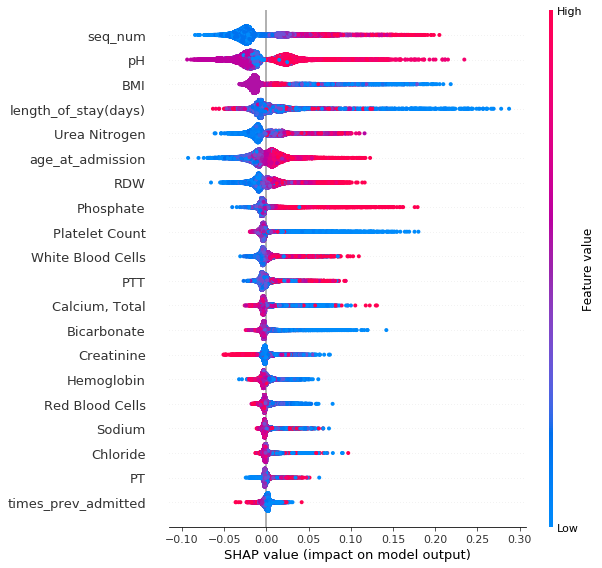

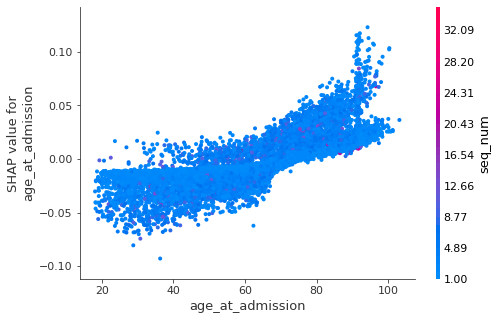

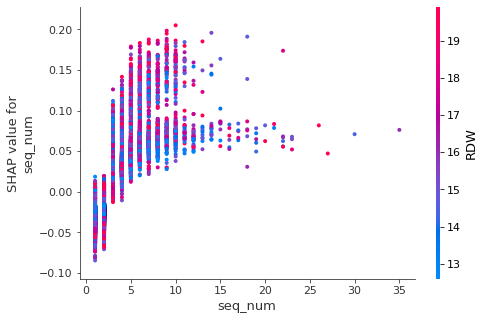

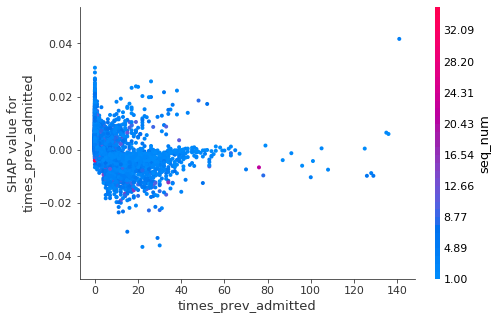

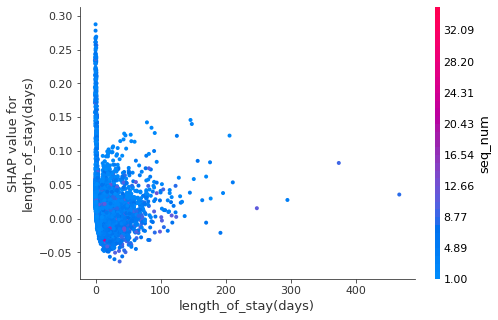

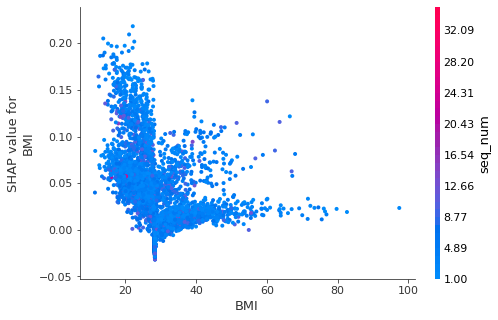

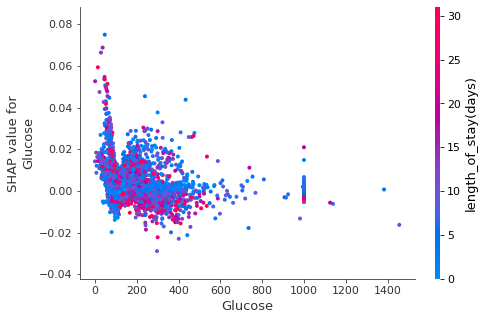

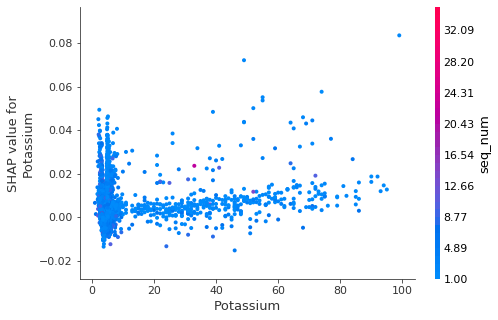

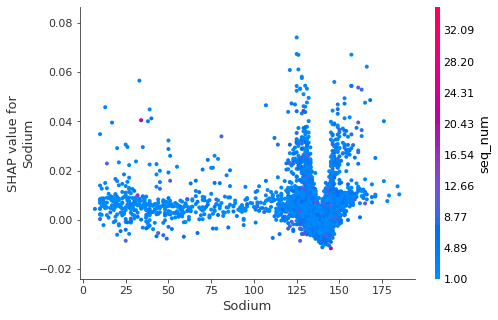

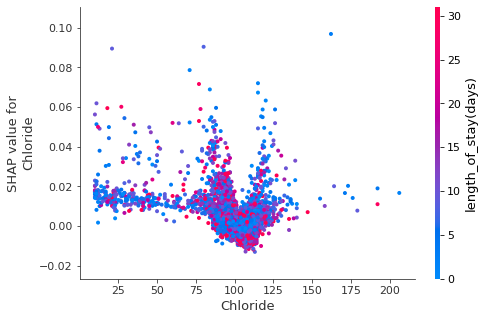

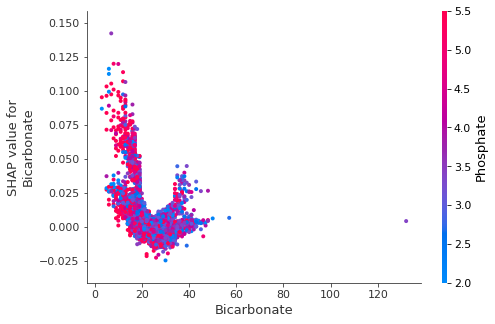

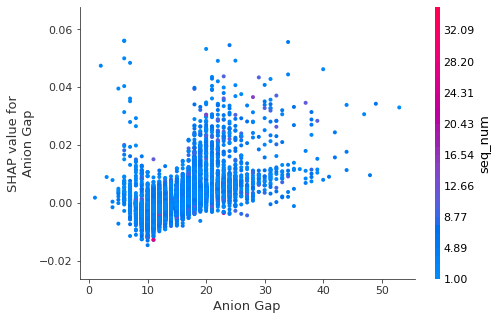

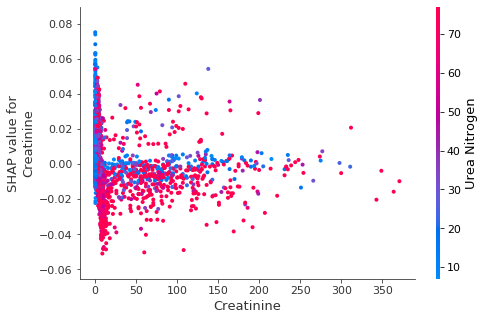

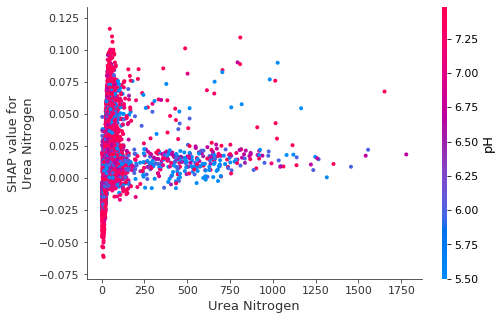

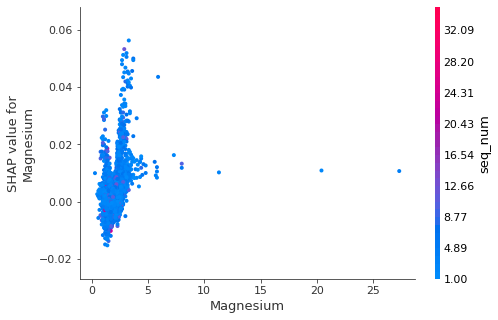

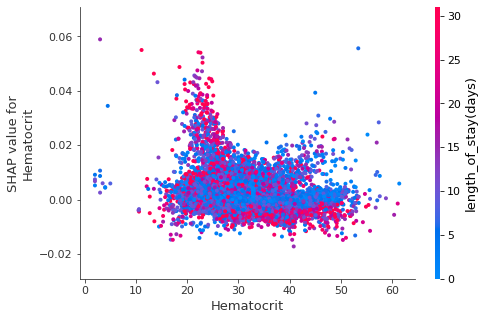

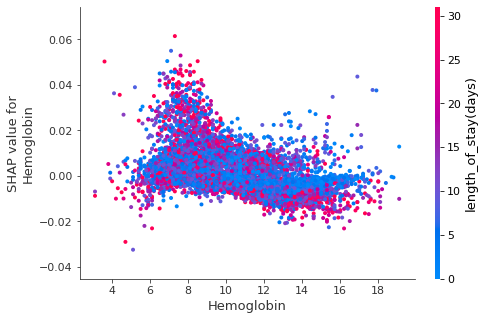

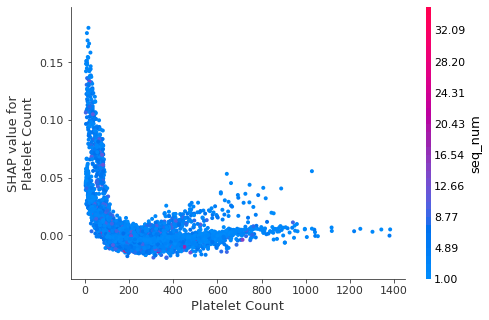

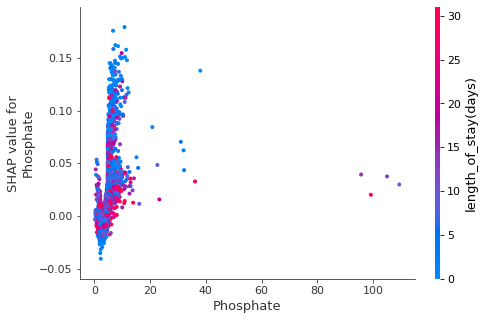

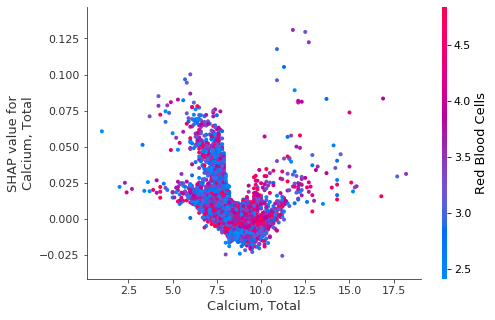

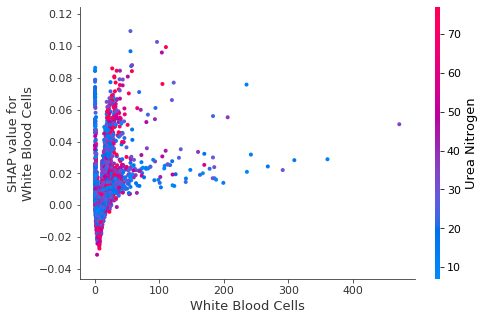

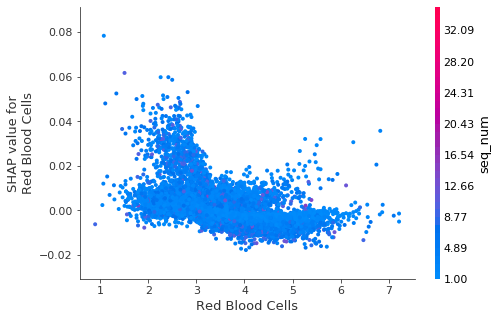

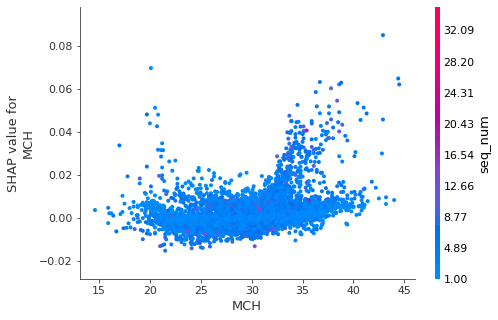

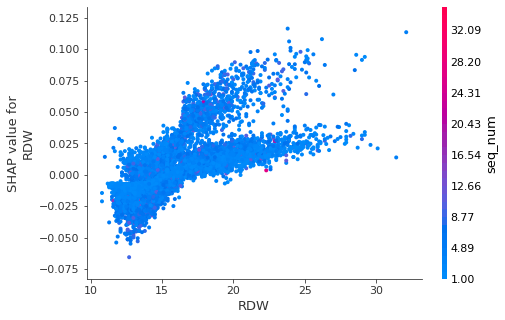

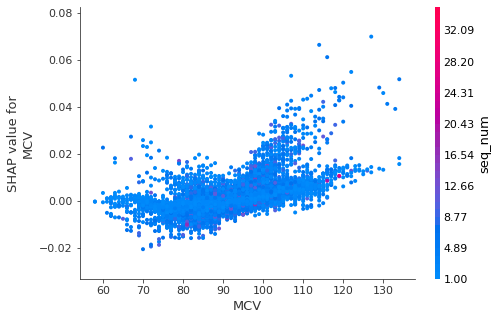

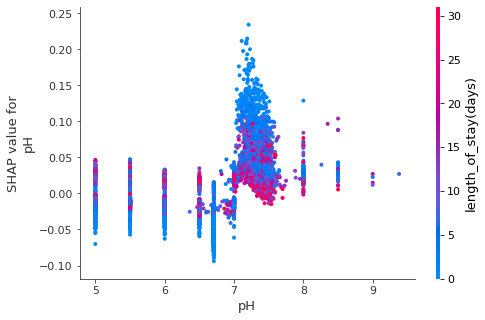

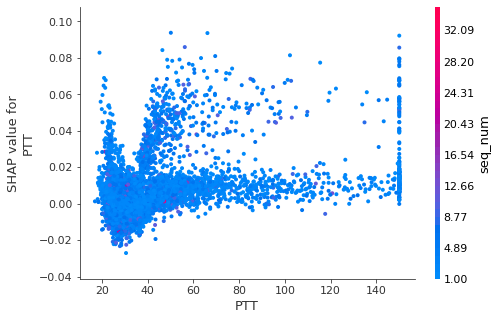

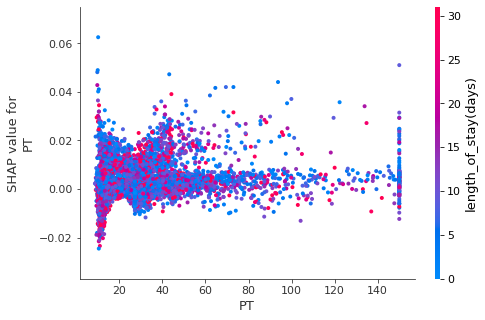

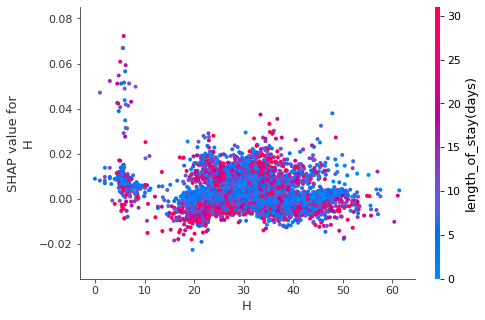

In [6]:
shap_values = explainer.shap_values( X_no_cat)
shap.summary_plot(shap_values[1],X_no_cat ,feature_names=feature_names)
for predictor in feature_names:
    if predictor not in cat_feature_names:
        shap.dependence_plot(predictor, shap_values[1],X_no_cat ,feature_names=feature_names)

## XGBOOST

In [7]:
xgb_classifier = xgb.XGBClassifier(objective = "binary:logistic",random_state=rand_state)
xgb_params = {
        'learning_rate': (0.01, 0.05,0.1),
        'min_child_weight': [3, 5, 10],
        'gamma': [0.5, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': list(range(5,30)),
        'scale_pos_weight': list(range(scale_pos_weight_min,3*scale_pos_weight_min))
}
model = strat_cv_it(xgb_classifier ,xgb_params,False,50)
explainer = shap.TreeExplainer(model)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   45.5s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  3.9min finished


0.8494361782573853

{'subsample': 0.6,
 'scale_pos_weight': 9,
 'min_child_weight': 10,
 'max_depth': 14,
 'learning_rate': 0.05,
 'gamma': 1.5,
 'colsample_bytree': 0.6}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        8.682107      0.238500         0.081449    5.421753e-03   
1        4.507607      0.118805         0.092420    1.243518e-03   
2        3.484677      0.037608         0.090425    1.695264e-03   
3        9.470332      0.210583         0.109042    1.694563e-03   
4        8.225661      0.074546         0.101728    3.549479e-03   
5        6.656194      0.063928         0.078124    3.082807e-03   
6        7.143864      0.083021         0.088763    3.257768e-03   
7        5.996624      0.057819         0.108377    5.171980e-03   
8        5.260594      0.018324         0.096741    2.154315e-03   
9        5.904205      0.081273         0.126662    5.340394e-03   
10       7.730984      0.048247         0.106382    3.290770e-03   
11       7.991620      0.119956         0.091422    2.617818e-03   
12       4.782872      0.060448         0.102060    4.484787e-03   
13       6.601007      0.047860         0.093417    2.617646e-03   
14       5.806134      0.067191         0.090757    1.628495e-03   
15       3.696444      0.046497         0.063164    1.244049e-03   
16       5.153546      0.024650         0.095079    1.695202e-03   
17       7.259912      0.090019         0.111701    2.936337e-03   
18       5.442773      0.036027         0.112034    2.618171e-03   
19       4.589389      0.018575         0.087101    2.488034e-03   
20       6.096357      0.030958         0.090092    1.244007e-03   
21       1.748987      0.006166         0.039229    9.404367e-04   
22       3.714064      0.026424         0.094414    2.487503e-03   
23       6.387579      0.043093         0.107379    4.908640e-03   
24       6.553136      0.043893         0.106049    3.291324e-03   
25       1.726713      0.003849         0.036569    1.243943e-03   
26       7.703059      0.193864         0.081117    4.178706e-03   
27       7.851994      0.115487         0.123337    2.487907e-03   
28       4.906873      0.025401         0.104388    2.049151e-03   
29       7.852992      0.111425         0.099069    4.704150e-04   
30       3.652562      0.007567         0.063164    4.696848e-04   
31       2.727037      0.000471         0.062500    2.487418e-03   
32       6.699743      0.051375         0.105385    2.049383e-03   
33       6.817096      0.107590         0.099068    2.350445e-03   
34       6.482325      0.034782         0.117020    4.975665e-03   
35       7.507250      0.069957         0.108044    1.694734e-03   
36       7.130923      0.046545         0.099069    2.617666e-03   
37       8.253254      0.116742         0.105385    1.880592e-03   
38       7.786170      0.071488         0.105385    2.860379e-03   
39       2.442466      0.017062         0.073802    2.936229e-03   
40       6.313443      0.016005         0.097739    2.973602e-07   
41       2.005633      0.006360         0.041888    8.143935e-04   
42       1.932830      0.022032         0.062167    1.695498e-03   
43       6.607323      0.057506         0.143949    8.630514e-03   
44       7.722341      0.028628         0.100065    2.049499e-03   
45       5.662851      0.008808         0.101728    1.411189e-03   
46       5.186458      0.008932         0.096741    2.935878e-03   
47       5.948420      0.101415         0.092420    3.390559e-03   
48       5.938113      0.082440         0.113696    7.099069e-03   
49       4.460068      0.078433         0.065824    5.619580e-07   

   param_subsample param_scale_pos_weight param_min_child_weight  \
0                1                     20                     10   
1              0.6                      9                     10   
2                1                     22                     10   
3                1                     12                      3   
4              0.6                     22                      5   
5                1                     15                      5   
6              0.6                     12                  

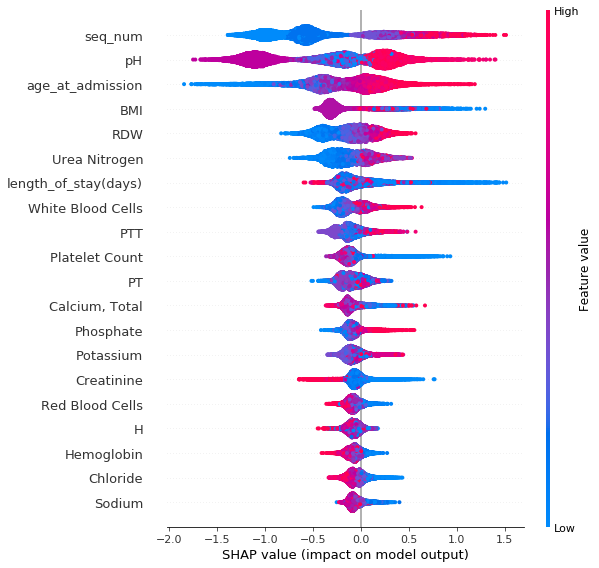

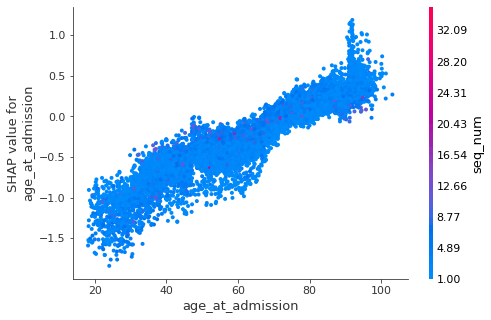

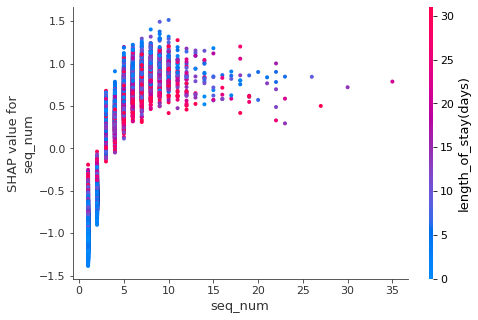

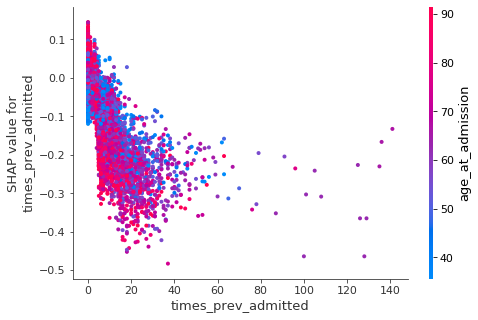

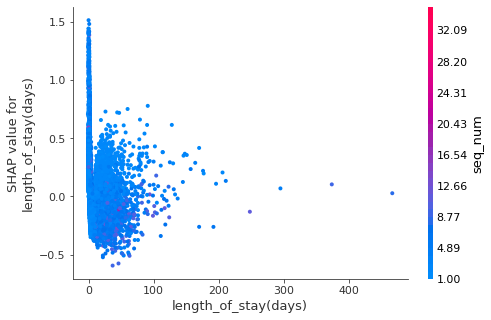

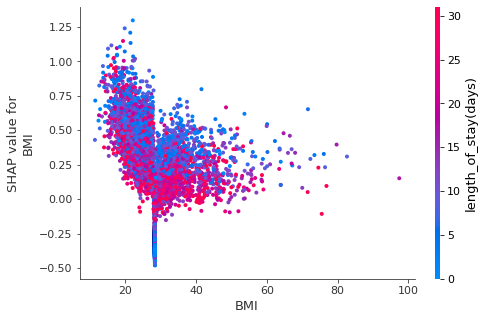

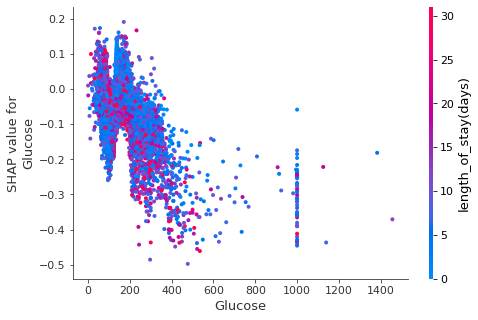

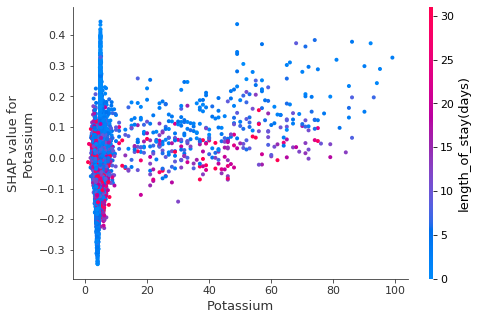

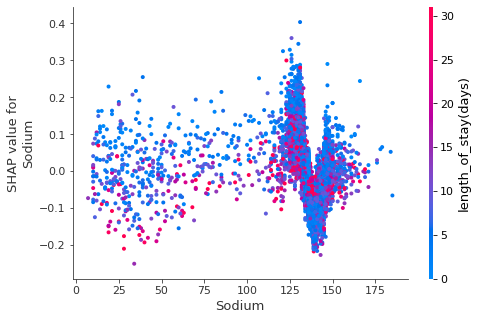

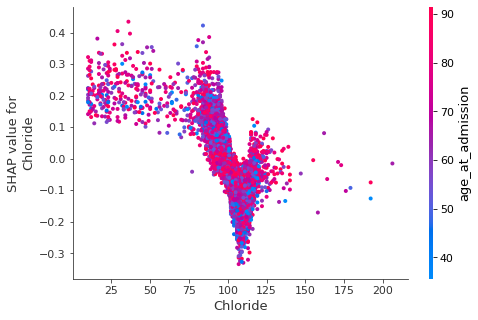

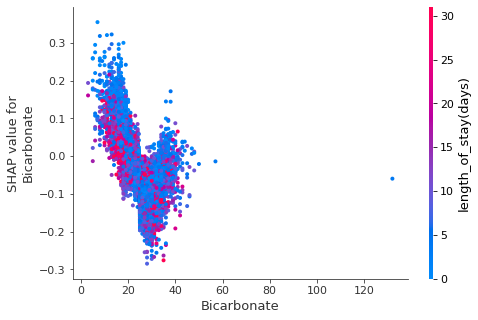

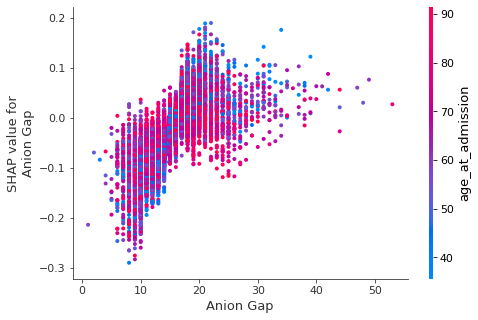

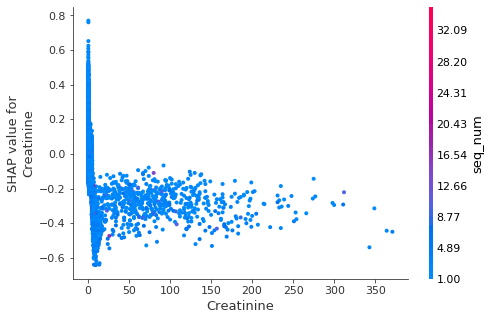

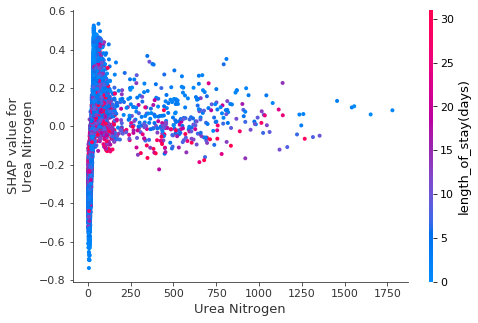

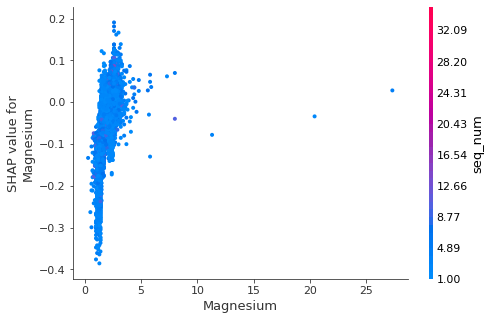

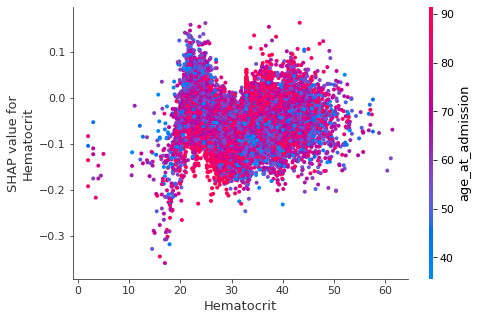

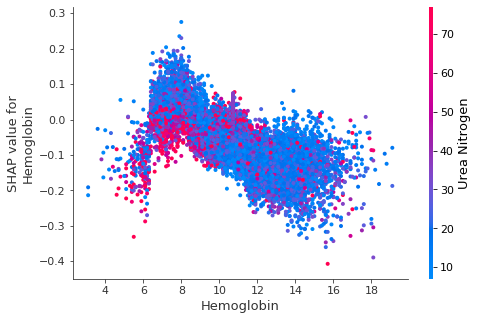

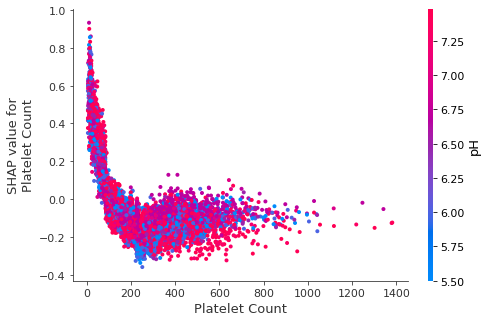

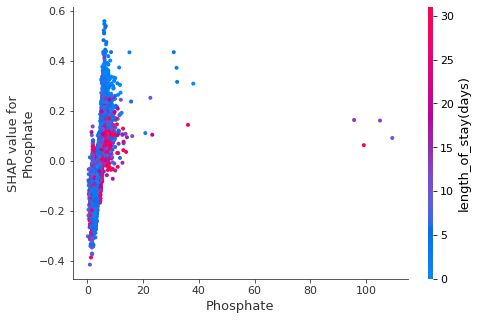

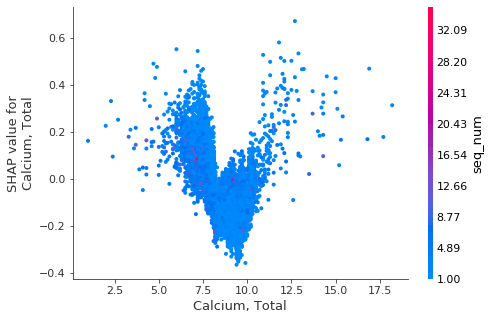

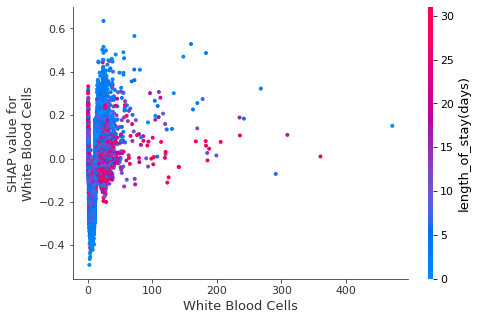

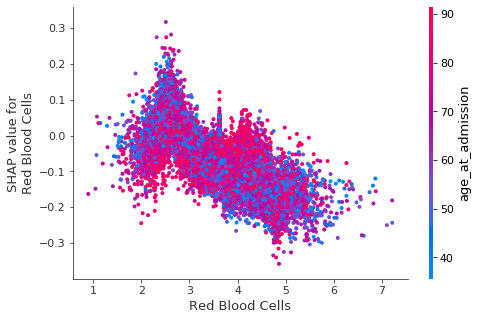

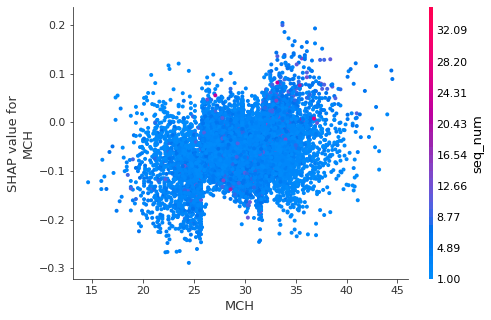

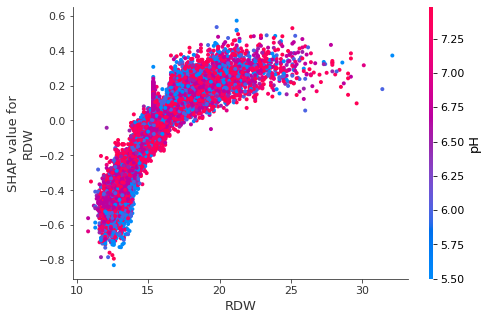

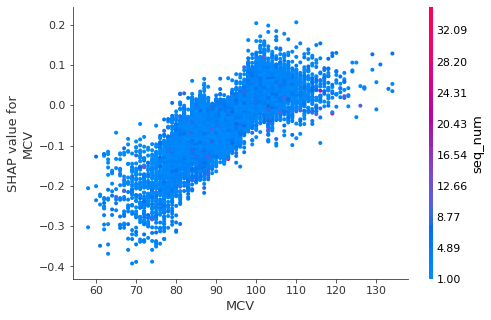

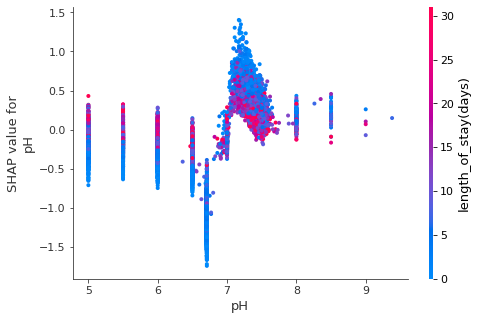

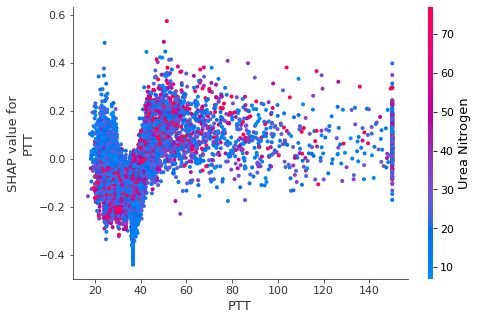

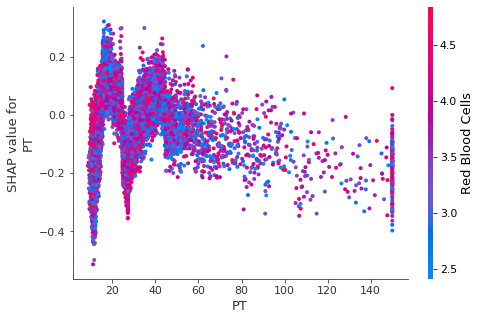

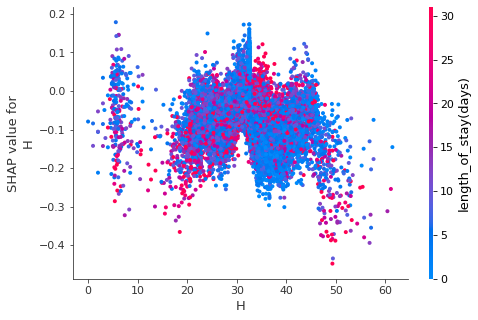

In [8]:
shap_values = explainer.shap_values( X_no_cat)
shap.summary_plot(shap_values,X_no_cat ,feature_names=feature_names)
for predictor in feature_names:
    if predictor not in cat_feature_names:
        shap.dependence_plot(predictor, shap_values,X_no_cat ,feature_names=feature_names)

# CatBoost

In [9]:
CB_classifier = CatBoostClassifier(
     cat_features=cat_features_indices,
     verbose=False,
     early_stopping_rounds=50,
)
CB_params = {
        'learning_rate': [0.05, 0.1],
        'depth': [4,5,6,7,8,9],
        'l2_leaf_reg': [1, 3, 5, 7, 8],
        'scale_pos_weight': list(range(scale_pos_weight_min,3*scale_pos_weight_min))

} 
# Note Attention: (ignore, affects speed(not result quality))
# Do not use one-hot encoding during preprocessing. This affects both the training speed and the resulting quality.
model = strat_cv_it(CB_classifier ,CB_params,True,25)
explainer = shap.TreeExplainer(model)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  6.9min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed: 20.2min finished


0.8437561213934699

{'scale_pos_weight': 11, 'learning_rate': 0.05, 'l2_leaf_reg': 5, 'depth': 4}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      118.055182      2.950695         0.992346        0.124650   
1       35.847768      1.404500         0.670207        0.015599   
2       36.168244      0.100290         0.694476        0.007566   
3      111.994398      1.699127         0.748997        0.059244   
4      114.981405      2.086789         0.788557        0.206240   
5       28.112129      0.950033         0.779914        0.046437   
6       29.951874      0.727293         0.689821        0.106493   
7       36.592442      1.370470         0.820139        0.060140   
8       24.227854      0.036962         0.595075        0.040367   
9      119.267274      1.798640         0.721071        0.186713   
10      49.325047      1.729609         0.623332        0.138492   
11      24.454248      0.440044         0.735034        0.080201   
12      29.110126      1.205372         0.774262        0.044321   
13     118.107044      1.338647         0.790220        0.162665   
14      51.268847      2.476399         0.756311        0.167470   
15      50.980619      1.366815         0.751988        0.077728   
16      24.253451      1.205579         0.979048        0.008933   
17      35.206151      0.418281         0.690487        0.068925   
18      73.170590      2.024916         0.695474        0.082781   
19     114.571836      0.349619         0.903250        0.075122   
20     113.829820      0.476826         0.851722        0.089438   
21      24.159370      0.473758         0.697136        0.106909   
22      75.744704      2.263295         0.764621        0.092152   
23      34.423246      0.653303         0.633971        0.040767   
24      60.097895      5.625981         0.362032        0.133496   

   param_scale_pos_weight param_learning_rate param_l2_leaf_reg param_depth  \
0                      12                0.05                 3           9   
1                      21                 0.1                 8           6   
2                      22                 0.1                 1           6   
3                      21                 0.1                 5           9   
4                      19                 0.1                 7           9   
5                      13                0.05                 7           5   
6                      15                 0.1                 3           5   
7                      22                0.05                 1           6   
8                      14                 0.1                 5           4   
9                      22                0.05                 5           9   
10                      8                0.05                 7           7   
11                     11                0.05                 5           4   
12                     18                 0.1                 3           5   
13                     19                 0.1                 8           9   
14                     14                0.05                 7           7   
15                     22                 0.1                 3           7   
16                     22                 0.1                 1           4   
17                      8                 0.1                 8           6   
18                      9                 0.1                 8           8   
19                     20                0.05                 7           9   
20                      9                 0.1                 7           9   
21                     16                 0.1                 7           4   
22                      8                0.05                 7           8   
23                     14                 0.1                 1           6   
24                      8                 0.1                 5           8   

                                               params  split0_test_score  \
0   {'scale_pos_weight': 12, 'learning_rate': 0.05...           0.846033   
1   {'scale_pos_weight': 21,

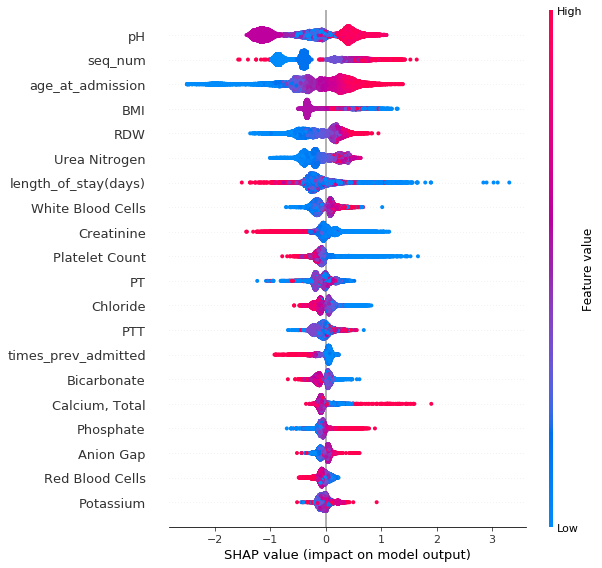

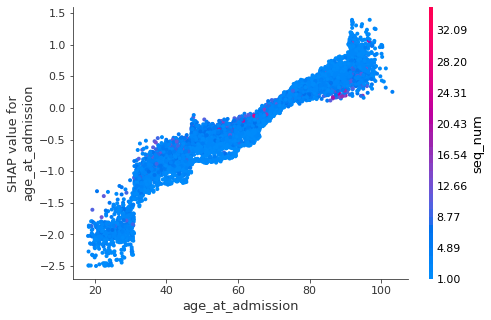

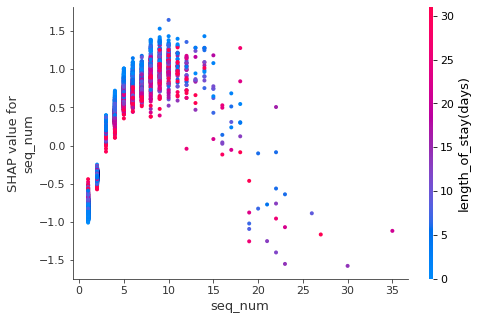

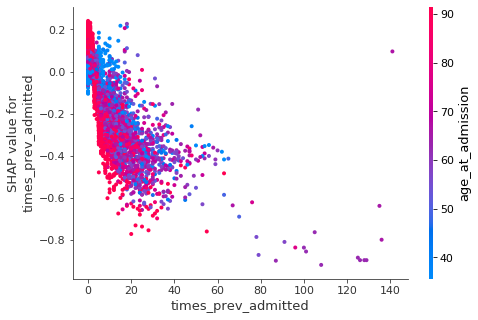

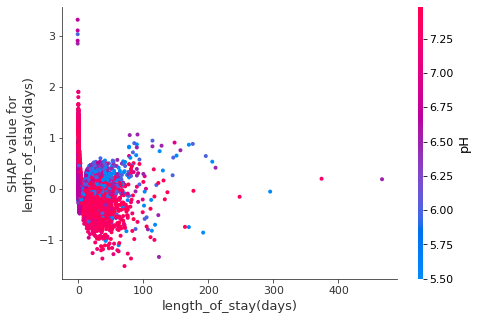

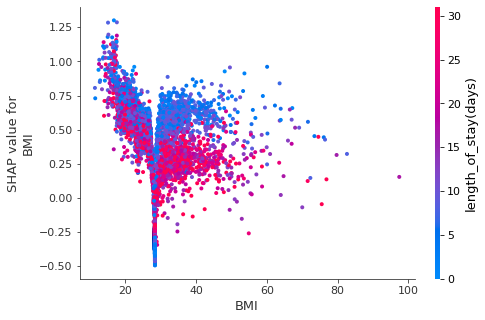

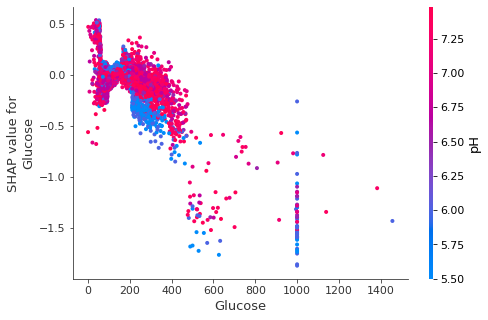

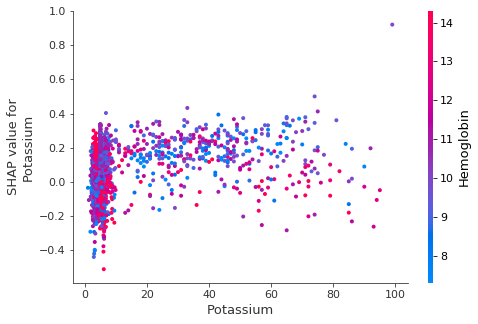

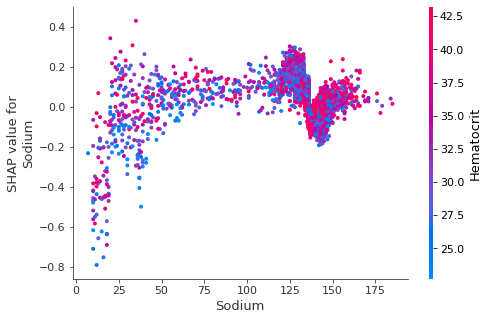

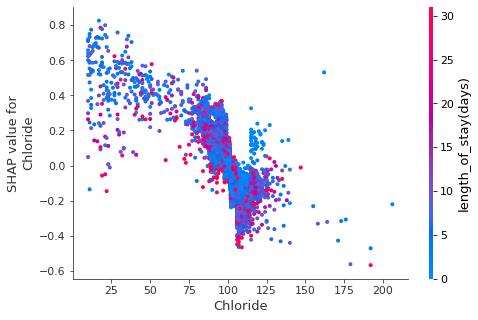

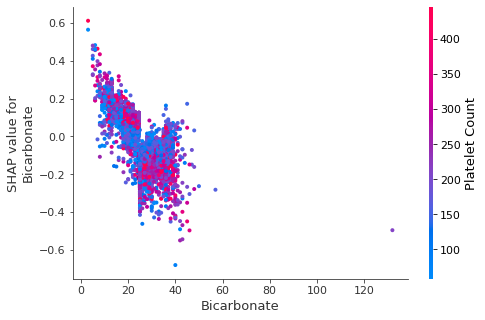

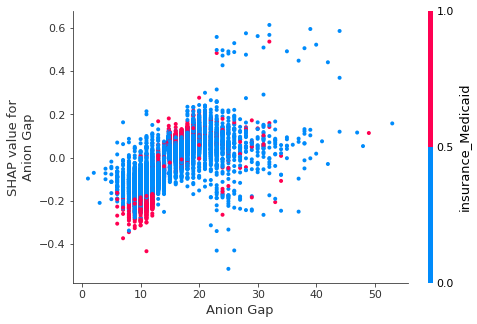

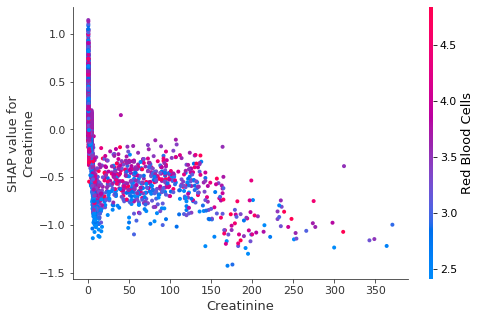

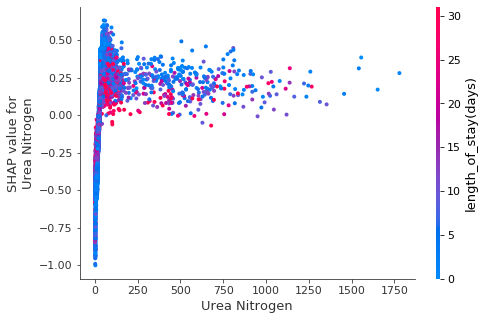

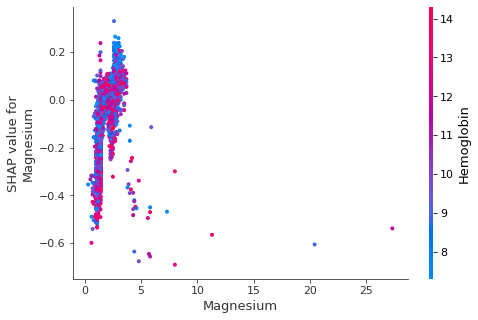

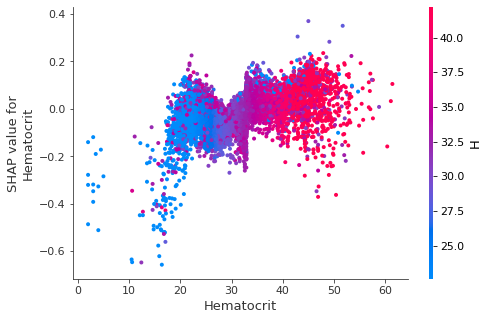

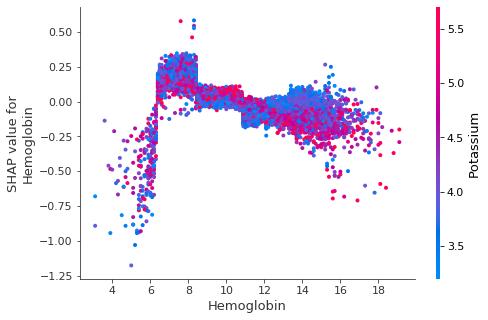

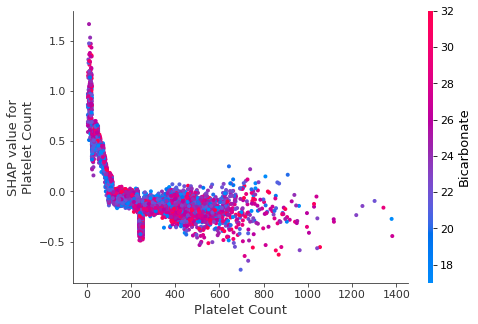

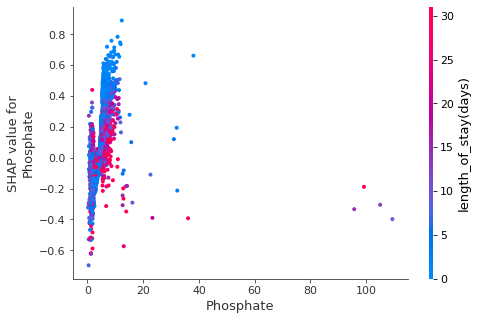

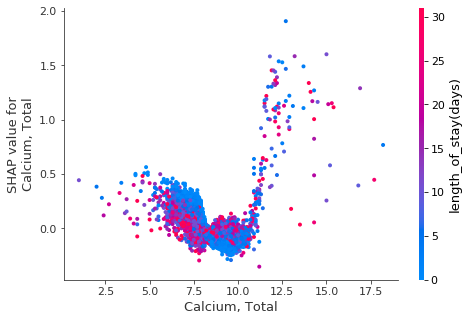

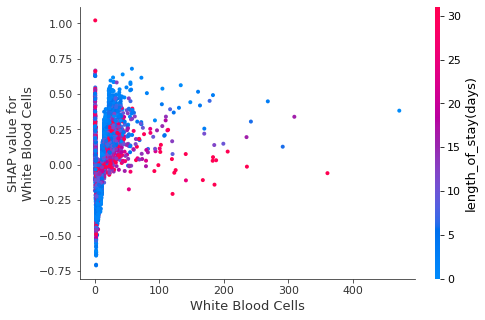

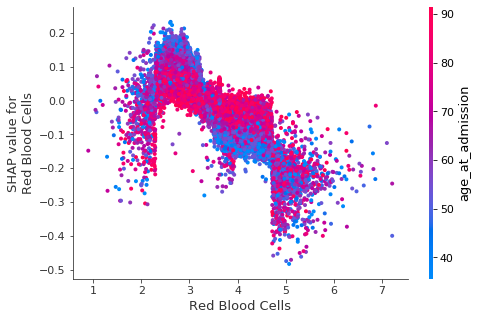

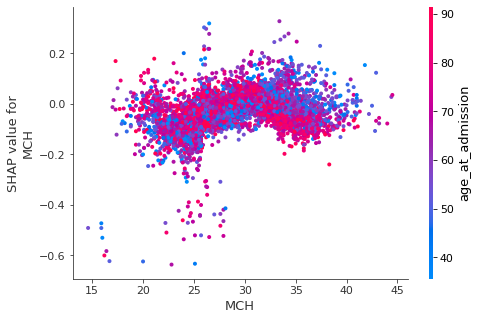

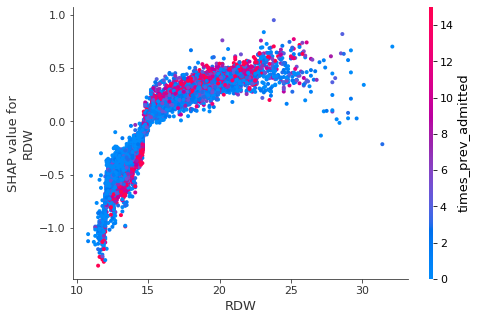

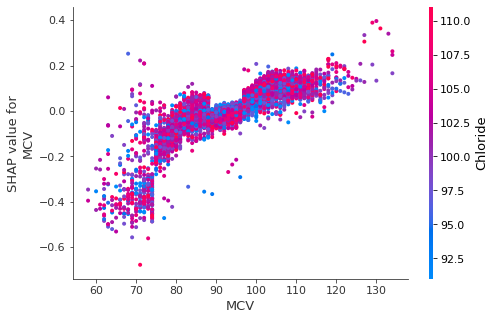

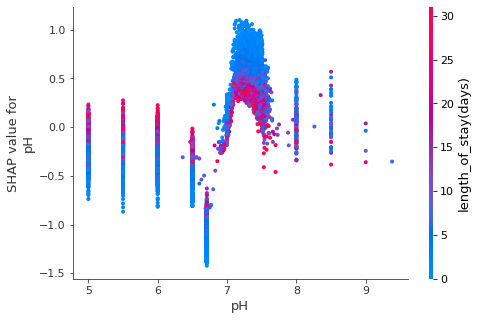

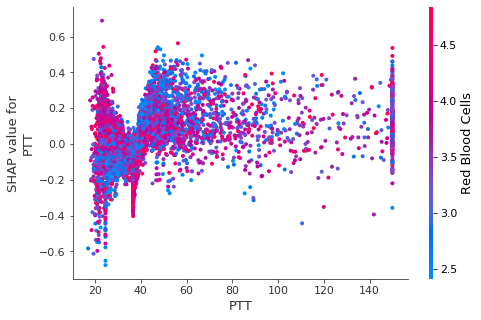

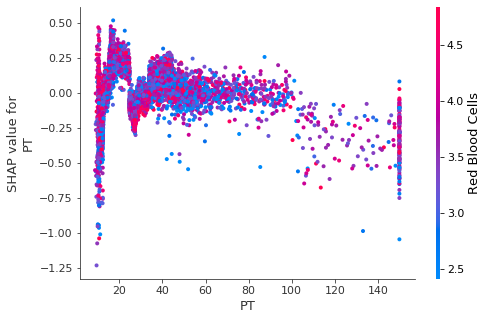

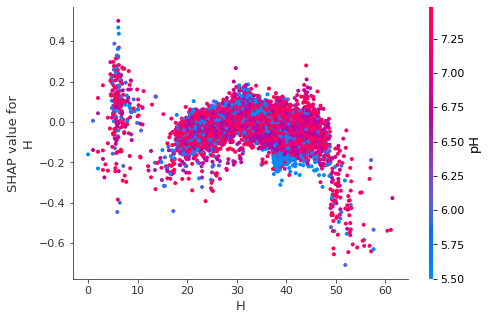

In [10]:
shap_values = explainer.shap_values(dataset_no_target)
shap.summary_plot(shap_values, dataset_no_target ,feature_names=feature_names)
for predictor in feature_names:
    if predictor not in cat_feature_names:
        shap.dependence_plot(predictor, shap_values ,dataset_no_target ,feature_names=feature_names)

# LightGBM

In [11]:
LGB_classifier = lgb.LGBMClassifier()
LGB_params = {
             'num_leaves': [1,5,8,10,15,20,35,40], 
             'min_child_samples': [1,5,10,20,50,100,200,300,400,500], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': [0.2,0,4,0.5, 0.6, 0.8, 1.0],
             'colsample_bytree': [0.6, 0.8, 1.0],
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'scale_pos_weight': list(range(scale_pos_weight_min,3*scale_pos_weight_min))

}
model = strat_cv_it(LGB_classifier ,LGB_params,True,50)
explainer = shap.TreeExplainer(model)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   28.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  3.0min finished


0.8536946013513936

{'subsample': 0.2,
 'scale_pos_weight': 20,
 'reg_lambda': 1,
 'reg_alpha': 1,
 'num_leaves': 35,
 'min_child_weight': 100.0,
 'min_child_samples': 10,
 'colsample_bytree': 0.8}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.053524  4.708086e-04         0.000000    0.000000e+00   
1        0.215098  8.153568e-03         0.029255    1.249286e-03   
2        0.254991  2.057332e-03         0.053849    9.665677e-06   
3        0.053523  4.701340e-04         0.000000    0.000000e+00   
4        0.313827  2.617606e-03         0.061835    8.141987e-04   
5        0.271276  2.822098e-03         0.054528    4.754830e-04   
6        0.543865  2.859010e-03         0.091090    4.556580e-04   
7        0.245009  2.057451e-03         0.054527    4.601322e-04   
8        0.053855  2.247832e-07         0.000000    0.000000e+00   
9        0.054851  3.541673e-06         0.000000    0.000000e+00   
10       0.357386  2.617144e-03         0.062498    2.046922e-03   
11       0.053529  4.776764e-04         0.000000    0.000000e+00   
12       0.271613  2.478712e-03         0.051862    2.247832e-07   
13       0.384655  4.492091e-03         0.069484    4.577150e-04   
14       0.377340  2.497704e-03         0.065476    1.232814e-03   
15       0.055519  4.703589e-04         0.000000    0.000000e+00   
16       0.286569  4.693980e-04         0.053867    1.208562e-05   
17       0.337098  2.443375e-03         0.080791    9.336624e-06   
18       0.316487  2.048829e-03         0.062499    4.844190e-04   
19       0.055185  4.708651e-04         0.000000    0.000000e+00   
20       0.054188  4.700779e-04         0.000000    0.000000e+00   
21       0.384970  3.248847e-03         0.079780    8.226803e-04   
22       0.692475  5.885919e-03         0.084773    8.141014e-04   
23       0.054844  8.143849e-04         0.000000    0.000000e+00   
24       0.053193  4.718762e-04         0.000000    0.000000e+00   
25       0.373002  1.628884e-03         0.067500    1.701979e-03   
26       0.252338  1.401186e-03         0.053185    4.751565e-04   
27       0.379318  4.484981e-03         0.074468    4.706399e-04   
28       0.054173  4.781170e-04         0.000000    0.000000e+00   
29       0.278255  8.220180e-04         0.051523    4.654242e-04   
30       0.636637  2.478329e-03         0.099069    4.705375e-04   
31       0.239027  2.049563e-03         0.052535    4.766023e-04   
32       0.053849  8.146488e-04         0.000000    0.000000e+00   
33       0.289227  7.973600e-04         0.060174    4.876845e-04   
34       0.053173  1.240031e-03         0.000000    0.000000e+00   
35       0.050857  8.056462e-04         0.000000    0.000000e+00   
36       0.362696  4.700217e-04         0.074148    9.359759e-04   
37       0.050857  8.145521e-04         0.000000    0.000000e+00   
38       0.312513  9.513423e-04         0.065815    8.060245e-04   
39       0.050857  8.993435e-06         0.000000    0.000000e+00   
40       0.769268  5.180747e-03         0.088756    8.141523e-04   
41       0.293887  4.022781e-03         0.053856    7.976519e-04   
42       0.381301  2.057776e-03         0.066164    4.651589e-04   
43       0.051522  9.456446e-04         0.000000    0.000000e+00   
44       0.051196  4.699660e-04         0.000000    0.000000e+00   
45       0.051522  1.236420e-03         0.000000    0.000000e+00   
46       0.052181  9.306586e-04         0.000000    0.000000e+00   
47       0.262292  1.636970e-03         0.053537    4.651483e-04   
48       0.052180  4.656084e-04         0.000000    0.000000e+00   
49       0.443822  8.625463e-03         0.089426    1.883683e-03   

   param_subsample param_scale_pos_weight param_reg_lambda param_reg_alpha  \
0                0                     19               10              50   
1              0.2                     20               10             0.1   
2              0.8                     20               50               0   
3                1                     20              0.1              50   
4              0.8                     22                0               0   
5              0.8                     19               20         

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


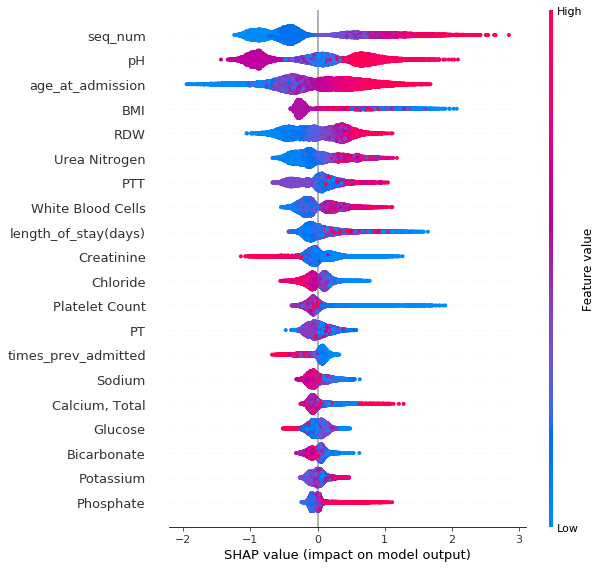

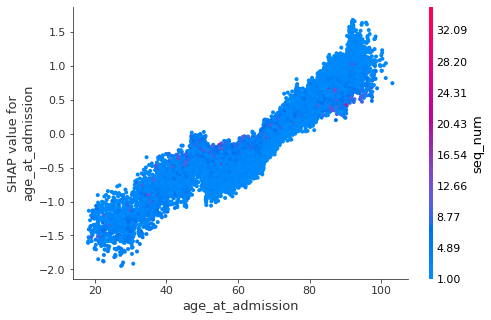

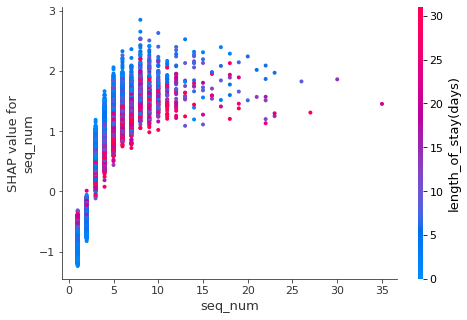

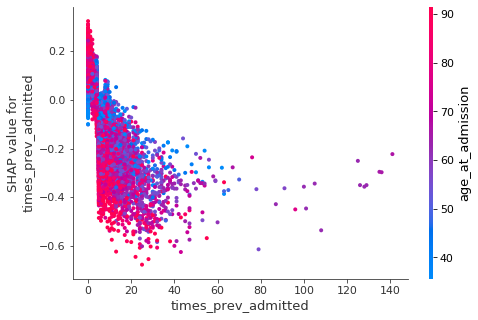

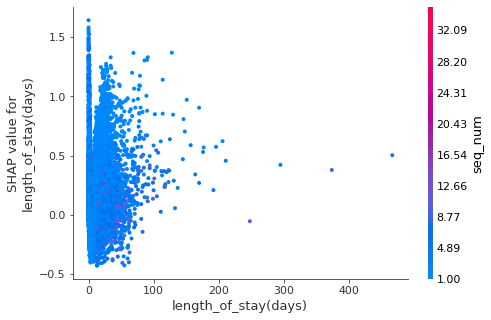

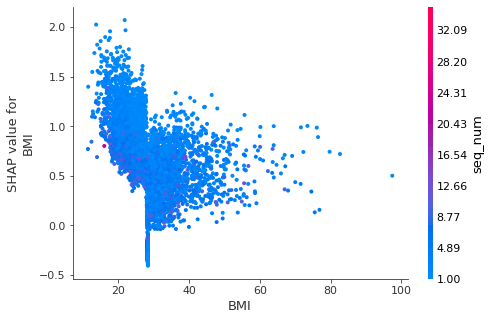

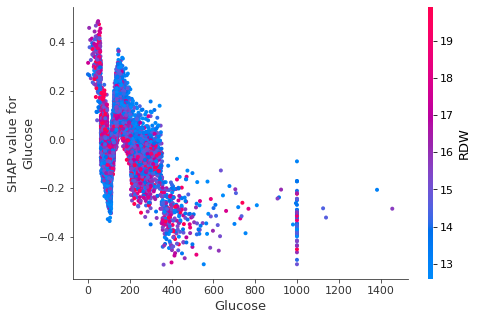

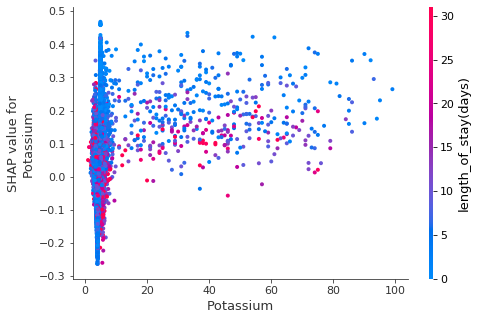

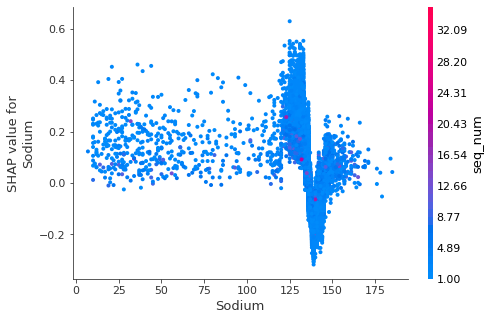

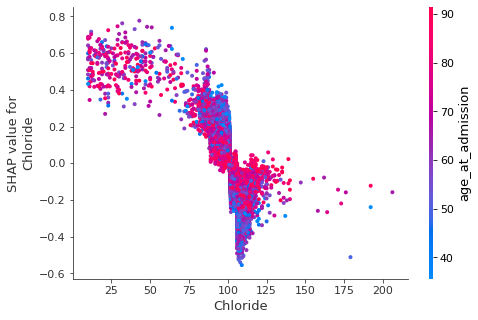

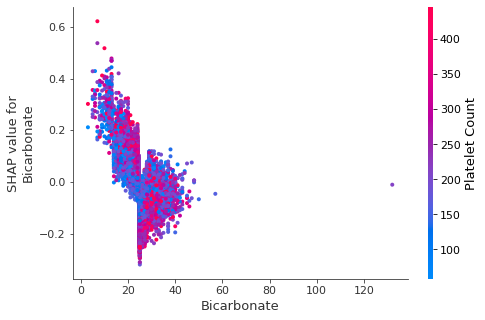

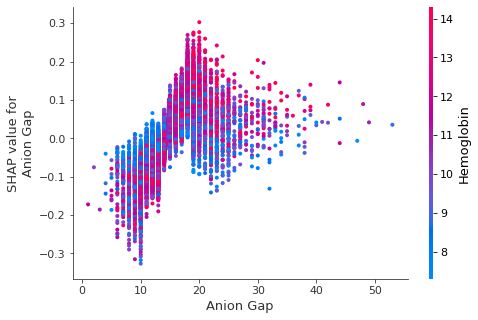

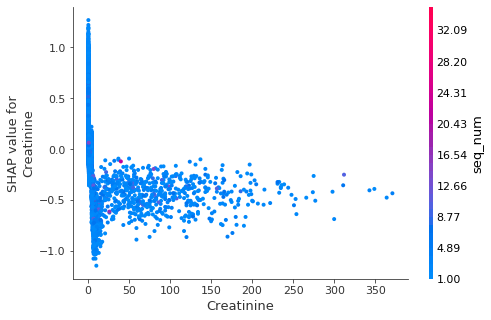

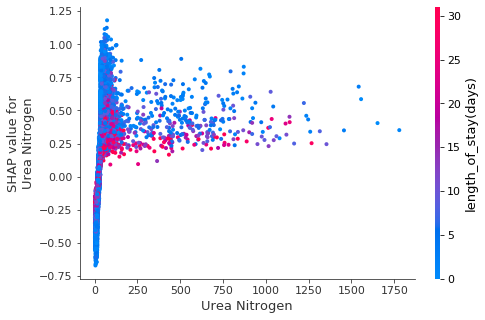

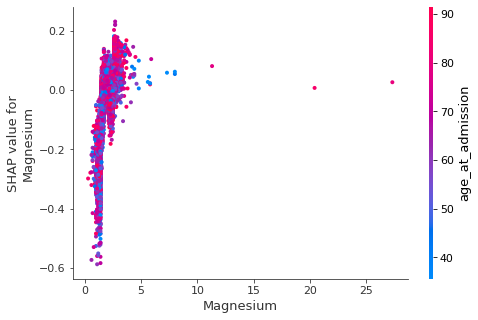

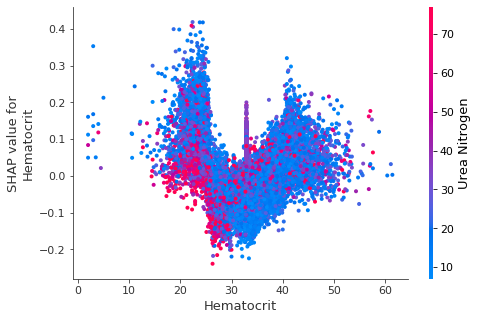

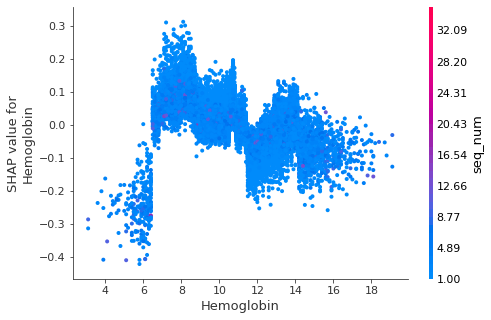

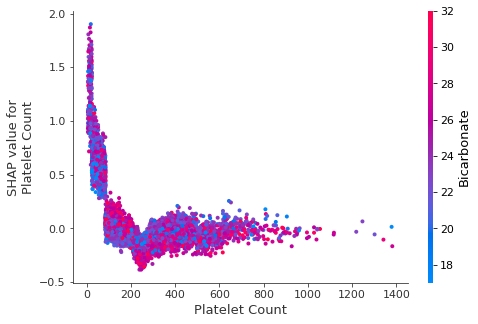

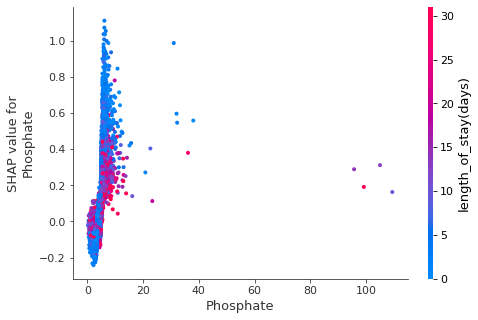

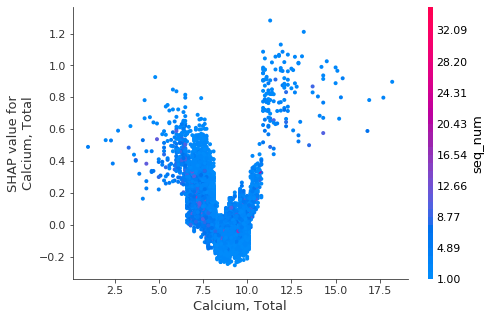

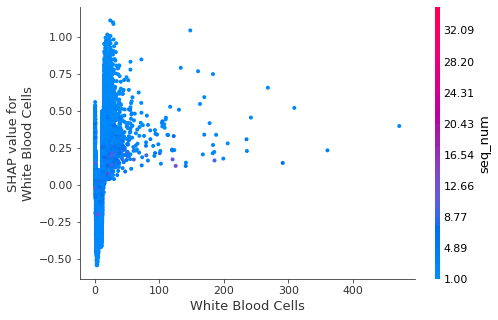

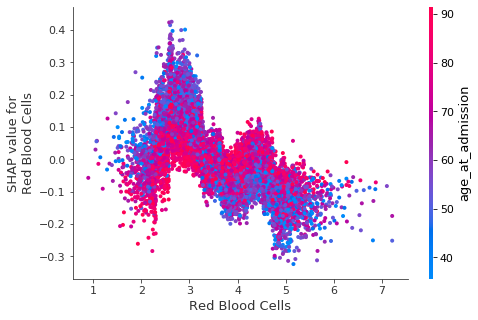

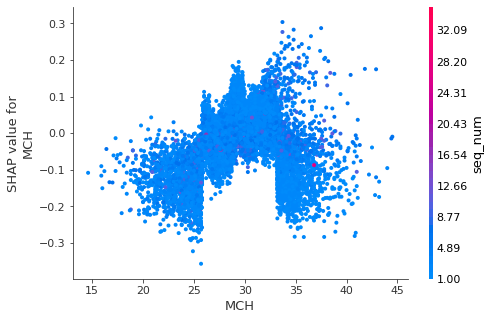

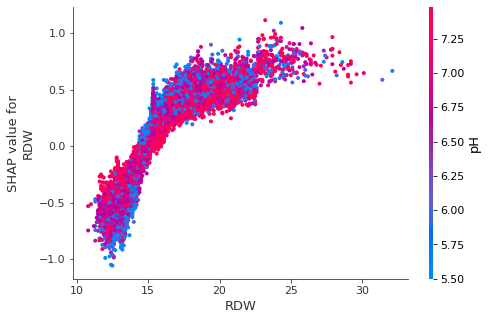

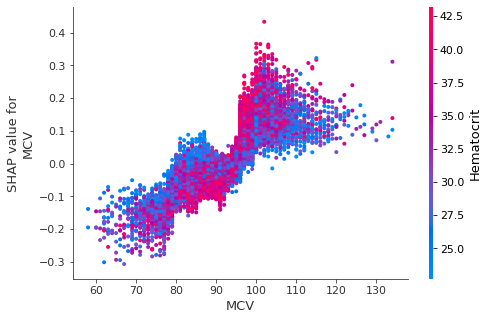

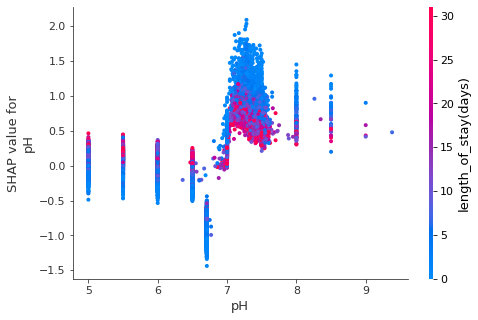

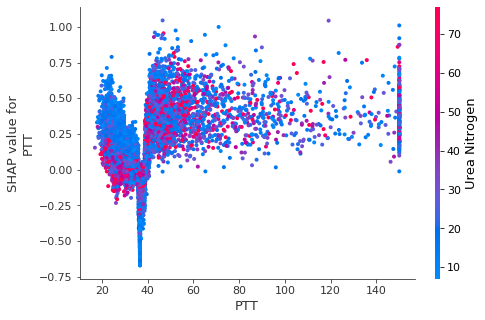

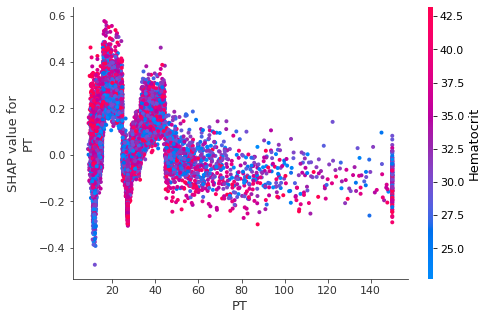

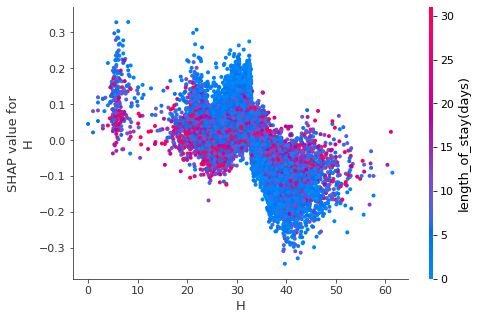

In [12]:
shap_values = explainer.shap_values(dataset_no_target)
shap.summary_plot(shap_values[1], dataset_no_target ,feature_names=feature_names)
for predictor in feature_names:
    if predictor not in cat_feature_names:
        shap.dependence_plot(predictor, shap_values[1] ,dataset_no_target ,feature_names=feature_names)